In [1]:
import os
import pandas as pd

def count_images_per_class(folder_path):
    image_counts = {}
    for subfolder in ['B2', 'B5', 'B6']:
        folder = os.path.join(folder_path, subfolder)
        if os.path.isdir(folder):
            num_images = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
            image_counts[subfolder] = num_images
    return image_counts

# Đường dẫn đến thư mục dữ liệu
data_dir = '/home/haipn/projects/data/dataver1'
train_folder = data_dir + '/train'
valid_folder = data_dir + '/valid'

# Đếm số ảnh ở mỗi nhãn
train_counts = count_images_per_class(train_folder)
valid_counts = count_images_per_class(valid_folder)

# Chuyển đổi dữ liệu thành DataFrame và in kết quả
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Number of Images'])
df_valid = pd.DataFrame(list(valid_counts.items()), columns=['Class', 'Number of Images'])

print("Train Data")
print(df_train)
print("Validation Data")
print(df_valid)

Train Data
  Class  Number of Images
0    B2               385
1    B5               432
2    B6               624
Validation Data
  Class  Number of Images
0    B2                97
1    B5               109
2    B6               157


In [2]:
import numpy as np

# Tính trọng số cho hàm loss
total_train_images = sum(train_counts.values())
class_weights = {
    class_name: total_train_images / (len(train_counts) * num_images)
    for class_name, num_images in train_counts.items()
}

# In trọng số
print("Class Weights:", class_weights)

Class Weights: {'B2': 1.2476190476190476, 'B5': 1.1118827160493827, 'B6': 0.7697649572649573}


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class H97_1__0_1_2(nn.Module):
    def __init__(self, num_classes=3):
        super(H97_1__0_1_2, self).__init__()
        # Khởi tạo mô hình với trọng số tiền huấn luyện
        self.model = efficientnet_b0(weights="DEFAULT")
        # Thay thế lớp phân loại cuối cùng
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Xây dựng model
print(len(train_counts))
num_classes = 3 # len(train_counts)
model = H97_1__0_1_2(num_classes=num_classes)

3


In [4]:
from PIL import Image
import random

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, subfolder in enumerate(['B2', 'B5', 'B6']):
            folder = os.path.join(folder_path, subfolder)
            for img_name in os.listdir(folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(folder, img_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Tăng cường dữ liệu
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_folder, transform=transform_train)
valid_dataset = CustomDataset(valid_folder, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32*4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32*4, shuffle=False)

In [5]:
len(train_loader)

12

In [6]:
len(valid_loader)

3

In [7]:
import wandb

wandb.login()

wandb: Currently logged in as: harito97 (harito). Use `wandb login --relogin` to force relogin


True

In [8]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Khởi tạo WandB
wandb.init(project="AI_Product_ThyroidCancerClassifier", name='H97_1__0_1_2_dataver1')

def train(model, train_loader, valid_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).cuda())
    optimizer = Adam(model.parameters(), lr=1e-4)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        valid_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_valid_loss = valid_loss / len(valid_loader)

        # Early stopping
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            torch.save(model.state_dict(), "output_ex/best_model_H97_1__0_1_2_dataver1.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

        # Tính toán các chỉ số
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        wandb.log({"epoch": epoch, "accuracy": accuracy, "f1_score": f1, "train_loss": epoch_loss, "valid_loss": epoch_valid_loss})

    wandb.finish()

# Train model
model.cuda()
train(model, train_loader, valid_loader)

Early stopping


accuracy,▁▅▅▆▆▇▆▇▇▇▇█▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
f1_score,▁▄▅▆▆▇▆▇▇▇▇████▇▇████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
valid_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂
accuracy,0.85399
epoch,20
f1_score,0.85414
train_loss,0.11745
valid_loss,0.44948


Accuracy: 0.8485
F1 Score: 0.8496


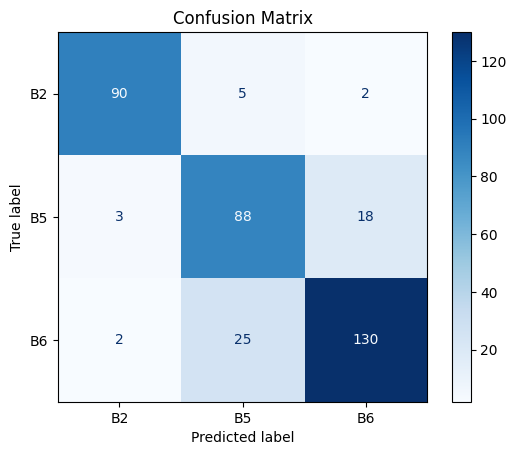

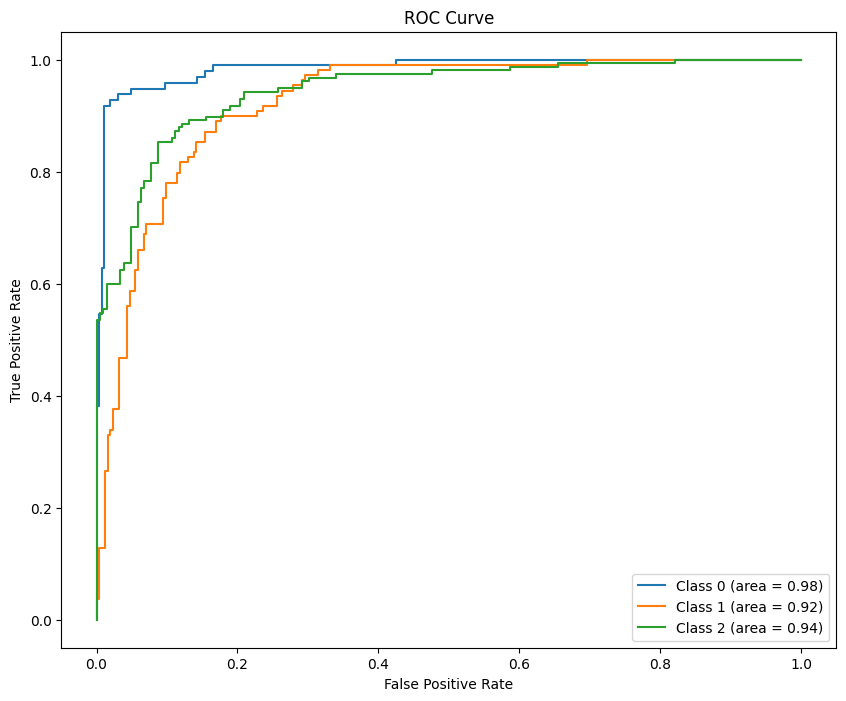

accuracy,▁
f1_score,▁
accuracy,0.84848
f1_score,0.84962


In [9]:
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, valid_loader):
    model.load_state_dict(torch.load('output_ex/best_model_H97_1__0_1_2_dataver1.pth', weights_only=True))
    model.eval()
    all_labels = []
    all_preds = []
    all_preds_prob = []
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds_prob = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_preds_prob.extend(preds_prob)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # Log metrics to WandB
    wandb.log({'accuracy': accuracy, 'f1_score': f1})
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B2', 'B5', 'B6'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC AUC
    all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2])
    all_preds_prob = np.array(all_preds_prob)
    
    plt.figure(figsize=(10, 8))
    for i in range(all_labels_bin.shape[1]):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (area = {auc(fpr, tpr):.2f})')
    
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

wandb.init(project="AI_Product_ThyroidCancerClassifier", name='H97_1__0_1_2_dataver1_test')
evaluate_model(model, valid_loader)
wandb.finish()